# Bernoulli HMM Example Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/bernoulli-hmm-example.ipynb)

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging
logger = logging.getLogger() 

class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

#### Imports and Plotting Functions 

In [3]:
import jax.random as jr
import jax.numpy as jnp
from jax import vmap

import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.optimize import linear_sum_assignment

from ssm_jax.hmm.models import BernoulliHMM
from ssm_jax.hmm.learning import hmm_fit_em

In [4]:
def gradient_cmap(colors, nsteps=256, bounds=None):
    """Return a colormap that interpolates between a set of colors.
    Ported from HIPS-LIB plotting functions [https://github.com/HIPS/hips-lib]
    Reference:
    https://github.com/lindermanlab/ssm/blob/646e1889ec9a7efb37d4153f7034c258745c83a5/ssm/plots.py#L20
    """
    ncolors = len(colors)
    # assert colors.shape[1] == 3
    if bounds is None:
        bounds = jnp.linspace(0,1,ncolors)


    reds = []
    greens = []
    blues = []
    alphas = []
    for b,c in zip(bounds, colors):
        reds.append((b, c[0], c[0]))
        greens.append((b, c[1], c[1]))
        blues.append((b, c[2], c[2]))
        alphas.append((b, c[3], c[3]) if len(c) == 4 else (b, 1., 1.))

    cdict = {'red': tuple(reds),
             'green': tuple(greens),
             'blue': tuple(blues),
             'alpha': tuple(alphas)}

    cmap = LinearSegmentedColormap('grad_colormap', cdict, nsteps)
    return cmap

In [5]:
def find_permutation(z1, z2):
    K1 = z1.max() + 1
    K2 = z2.max() + 1

    perm = []
    for k1 in range(K1):
      indices = jnp.where(z1==k1)[0]
      counts = jnp.bincount(z2[indices])
      perm.append(jnp.argmax(counts))

    return jnp.array(perm)

In [6]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()
    
def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes([axs[1].get_position().x1 + 0.07,
                        axs[1].get_position().y0,
                        0.02,
                        axs[1].get_position().y1-axs[1].get_position().y0])
    plt.colorbar(out, cax=cax)
    plt.show()

def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * jnp.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()
    
def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), '--', label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()

# Bernoulli HMM

### As before, let's create a true model

In [7]:
num_states = 5
num_channels = 10

initial_probabilities = jnp.ones((num_states,)) / (num_states * 1.)
transition_matrix = 0.90 * jnp.eye(num_states) + 0.10 * jnp.ones((num_states, num_states)) / num_states
probs_prior = tfd.Beta(1, 1)
emission_probabilities = probs_prior.sample(seed=jr.PRNGKey(0),
                                            sample_shape=(num_states, num_channels))

true_hmm = BernoulliHMM(initial_probabilities,
                        transition_matrix,
                        emission_probabilities)

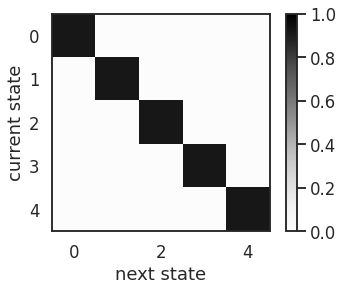

In [8]:
plot_transition_matrix(true_hmm.transition_matrix)

### Acessing model parameters
The HMM was initialized with a transition matrix, but what about the emission probabilities? Unless they are explicitly given to the constructor, they are initialized randomly using the specified seed.  We can access them via model properties.

In [9]:
print("Emission probabilities (num states x num emission_dims (aka channels)):")
print(true_hmm.emission_probs)

Emission probabilities (num states x num emission_dims (aka channels)):
[[0.5101075  0.37463653 0.15845723 0.92877907 0.915876   0.2781816
  0.07606837 0.67227226 0.02824288 0.8792381 ]
 [0.60166305 0.17131579 0.8953847  0.16232777 0.21001732 0.3545916
  0.37099373 0.65532225 0.5685262  0.5294375 ]
 [0.86292917 0.07698138 0.21009283 0.48858947 0.91662025 0.9897732
  0.7091185  0.19263755 0.57043606 0.5730329 ]
 [0.977979   0.7871507  0.49274066 0.9426948  0.4235999  0.36467838
  0.07442135 0.20010759 0.11953039 0.34888312]
 [0.59595954 0.65374476 0.6496834  0.7097438  0.03907026 0.29472747
  0.20753238 0.11125415 0.6862083  0.60004115]]


### From the true model, we can sample synthetic data

In [10]:
rng = jr.PRNGKey(0)
num_timesteps = 500

states, data = true_hmm.sample(rng, num_timesteps)

### Let's view the synthetic data

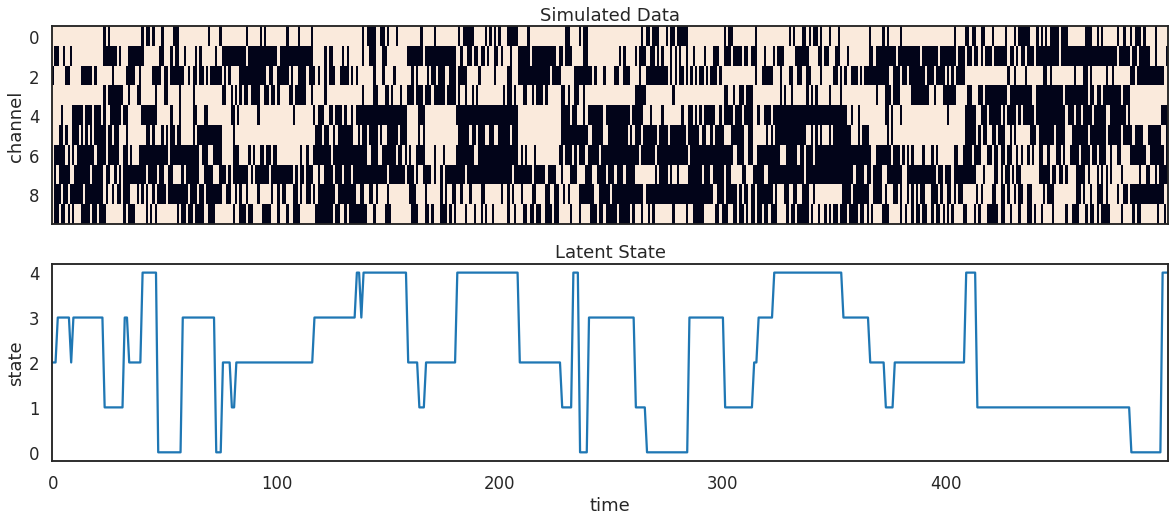

In [11]:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("channel")
axs[0].set_title("Simulated Data")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

## Fit HMM using exact EM update

In [12]:
emission_probabilities = probs_prior.sample(seed=jr.PRNGKey(32),
                                            sample_shape=(num_states, num_channels))
test_hmm = BernoulliHMM(initial_probabilities,
                        transition_matrix,
                        emission_probabilities)

In [13]:
batch_size = 1
num_iters = 20
test_hmm, lps, posterior = hmm_fit_em(test_hmm, data.reshape((batch_size, num_timesteps, num_channels)), num_iters=num_iters)

  0%|          | 0/20 [00:00<?, ?it/s]

Traced<ShapedArray(float32[1,500,5])>with<DynamicJaxprTrace(level=0/1)>


Text(0, 0.5, 'log likelihood')

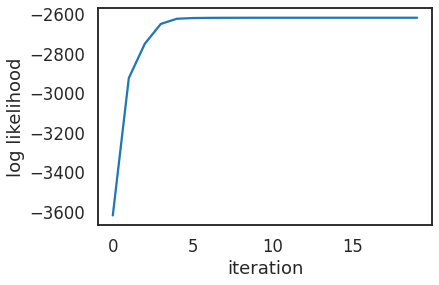

In [14]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

In [15]:
test_hmm.transition_matrix

DeviceArray([[9.4317383e-01, 2.4364501e-02, 1.1691556e-02, 1.1753501e-02,
              9.0166740e-03],
             [2.4959171e-02, 9.2062330e-01, 3.7846642e-31, 1.7025385e-02,
              3.7392229e-02],
             [2.3389093e-08, 1.9437252e-02, 9.0362060e-01, 7.6942123e-02,
              2.8513011e-21],
             [2.4482619e-02, 1.7036950e-02, 9.3621258e-03, 9.2188257e-01,
              2.7235655e-02],
             [2.8603408e-08, 3.9837979e-02, 2.6580893e-02, 9.2564123e-03,
              9.2432469e-01]], dtype=float32)

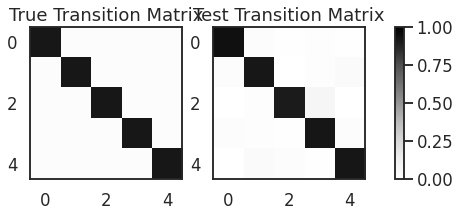

In [16]:
# Compare the transition matrices
compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

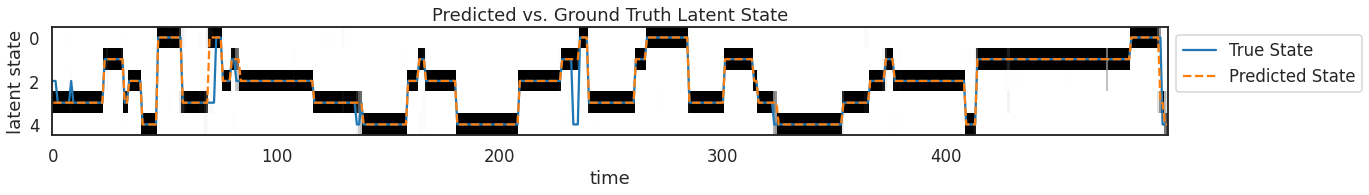

In [17]:
# Posterior distribution
Ez = posterior.smoothed_probs.reshape(-1, num_states)
perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)

# Fit Bernoulli Over Multiple Trials

In [18]:
rng = jr.PRNGKey(0)
num_trials = 5
keys = jr.split(rng, num_trials)
num_timesteps = 500

all_states, all_data = vmap(true_hmm.sample, in_axes=(0, None))(keys, num_timesteps)

In [19]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [20]:
num_iters=100
test_hmm, lps, posterior = hmm_fit_em(test_hmm, all_data, num_iters=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Traced<ShapedArray(float32[5,500,5])>with<DynamicJaxprTrace(level=0/1)>


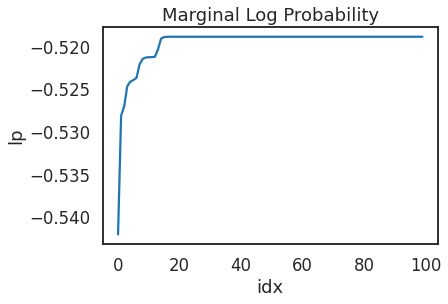

In [21]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(jnp.array(lps) / data.size)

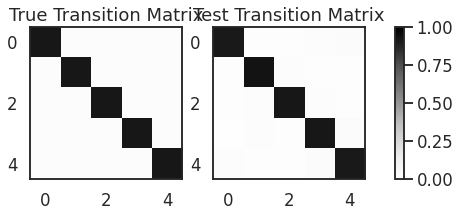

In [22]:
compare_transition_matrix(true_hmm.transition_matrix, test_hmm.transition_matrix)

===== Trial: 0 =====


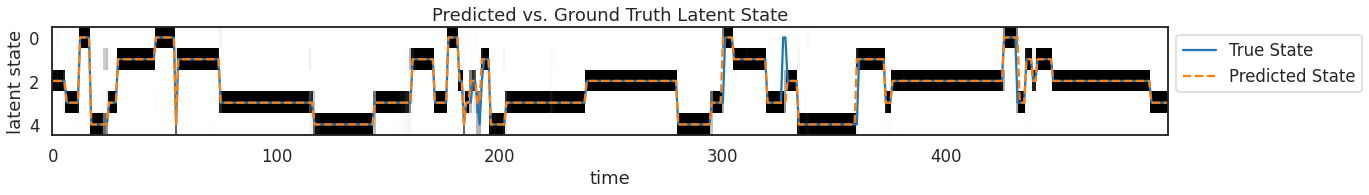

===== Trial: 1 =====


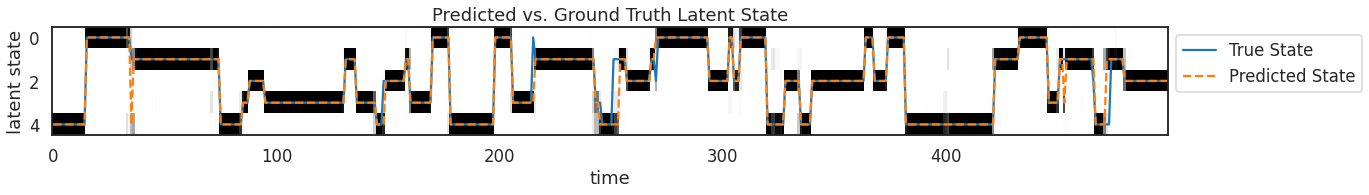

===== Trial: 2 =====


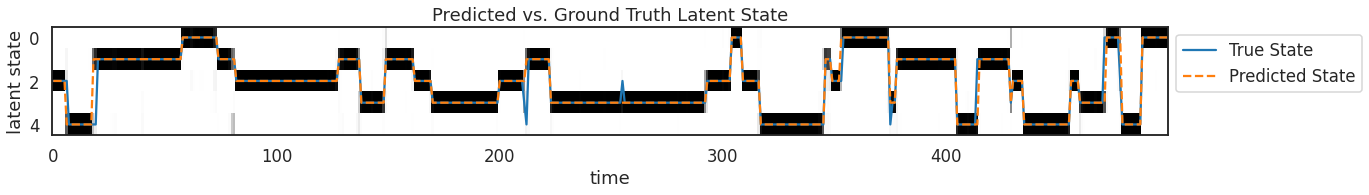

In [23]:
# For the first few trials, let's see how good our predicted states are
for trial_idx in range(3):
    print("="*5, f"Trial: {trial_idx}", "="*5)
    Ez = posterior.smoothed_probs[trial_idx]
    states = all_states[trial_idx]
    perm = find_permutation(states, jnp.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)